In [19]:
#https://www.kaggle.com/c/quora-insincere-questions-classification/

Embeddings allowed on the competition (GoogleNews-vectors-negative300 / glove.840B.300d / paragram_300_sl999/ wiki-news-300d), do not take context into account like BERT, so we had the idea to use BERT for this competition, just for the sake of learning and exploring.

<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

In [20]:
#Set up tensorflow runtime
!nvidia-smi

Tue Aug 10 18:46:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |    736MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
# Install TensorFlow and TensorFlow Model Garden : The TensorFlow Model Garden is a repository with a number of different implementations 
# of state-of-the-art (SOTA) models and modeling solutions for TensorFlow users. 
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [22]:
!git clone --depth 1 -b v2.5.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [23]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

In [24]:
# Download and Import the Quora Insincere Questions Dataset
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [25]:
print("TF Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Hub version:  0.12.0
GPU is available


[Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). 

In [26]:
!pip install sklearn

In [27]:
# Decompress and read the data into a pandas DataFrame.
import numpy as np
import pandas as pd

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
#If low_memory=False , then whole columns will be read in first, and then the proper types determined. 
#For example, the column will be kept as objects (strings) as needed to preserve information. 
#If low_memory=True (the default), then pandas reads in the data in chunks of rows, then appends them together.
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip',
                 low_memory=False)
df.shape

(1306122, 3)

In [30]:
df.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


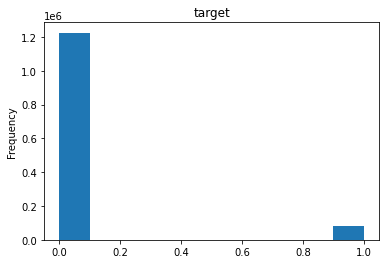

In [31]:
df.target.plot(kind='hist', title='target');

In [32]:
#Create tf.data.Datasets for Training and Evaluation
train_df, remaining = train_test_split(df,  train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [33]:
with tf.device('/cpu:0'):
  #returns a python iterable 
  train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(3):
    print(text)
    print(label)

tf.Tensor(b'Why do Indians have low IQ DNA as confirmed in the world IQ ranking and PISA scores?', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'Is it possible to make a dumpling that contains only a specific meat?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"I have found out, couples ike to raise marriage issues in the middle of night and start yelling at each other until kids can't sleep. What's your opinion on this matter?", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [34]:
#Download a Pre-trained BERT Model from TensorFlow Hub
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories : 1 = insincere qst, 0 = sincere qst
max_seq_length = 128 # maximum length of (token) input sequences, for BERT we can use 512, but due to material constraints, I will use 128
train_batch_size = 32

# Get BERT layer :
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
# trainable=True, the doc said that it is a best practice to fine Tune all the hyperparameters of our model
# It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
#Instanciate the Tokenizer:

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [35]:
#test : Yes, we saw a comma but it is attached to another word
tokenizer.wordpiece_tokenizer.tokenize('hi , how are you doing?')
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [36]:
#test (Convert the tokens to token_ids that bert requires)
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

In [37]:
#Tokenize and Preprocess Text for BERT


<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [38]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, 
                                                       example, 
                                                       label_list,
                                                       max_seq_length,
                                                       tokenizer,
                                                       )
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [39]:
# Wrap a Python Function into a TensorFlow op for Eager Execution
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [40]:
# Create a TensorFlow Input Pipeline with tf.data
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [41]:
# data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [42]:
# data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [58]:
# Building the model
#Add a Classification Head to the BERT Layer
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
# There are two outputs: a pooled_output of shape [batch_size, 768] with representations for the entire input sequences 
# and a sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context).
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

In [44]:
# Fine-Tune BERT for Text Classification
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

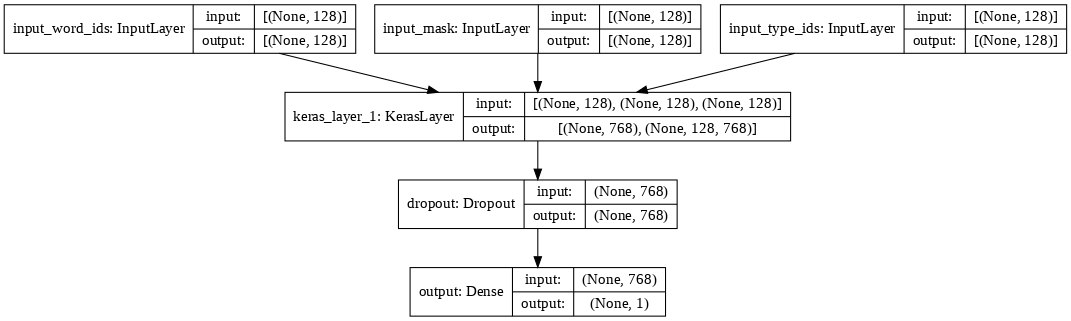

In [45]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [46]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
306/306 [==============================] - 270s 831ms/step - loss: 0.1721 - binary_accuracy: 0.9391 - val_loss: 0.1156 - val_binary_accuracy: 0.9469
Epoch 2/4
306/306 [==============================] - 255s 829ms/step - loss: 0.0947 - binary_accuracy: 0.9642 - val_loss: 0.1312 - val_binary_accuracy: 0.9438
Epoch 3/4
306/306 [==============================] - 254s 829ms/step - loss: 0.0472 - binary_accuracy: 0.9841 - val_loss: 0.1359 - val_binary_accuracy: 0.9563
Epoch 4/4
306/306 [==============================] - 255s 830ms/step - loss: 0.0213 - binary_accuracy: 0.9929 - val_loss: 0.2039 - val_binary_accuracy: 0.9542


In [47]:
# Evaluate the BERT Text Classification Model
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

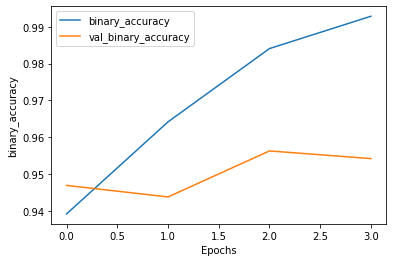

In [48]:
plot_graphs(history, 'binary_accuracy')

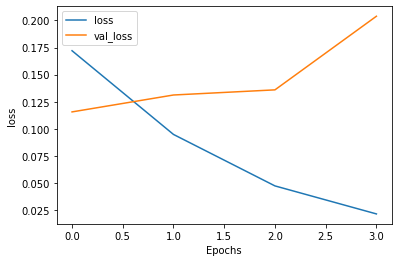

In [49]:
plot_graphs(history, 'loss')

In [50]:
model.evaluate(valid_data, verbose=1)

30/30 [==============================] - 9s 285ms/step - loss: 0.2039 - binary_accuracy: 0.9542


[0.20391719043254852, 0.9541666507720947]

In [54]:
sample_example = ["? ",\
                  "Always be real! ",\
                  "Because, she has a visit on the doc",\
                  "I love it ! "]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
#['Toxic' if pred >=0.5 else 'Sincere' for pred in preds]

In [55]:
preds

array([[0.00013204],
       [0.02113543],
       [0.00035309],
       [0.00638672]], dtype=float32)

In [56]:
# FIN NOTEBOOOOOOOOOOOOK